In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import segmentation_models_pytorch as sm
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from sklearn.model_selection import train_test_split
import albumentations as A
import os
from tqdm.notebook import tqdm

import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from tqdm import tqdm

from torchsummary import summary

/home/tenzing/apollo/avc/projects/archaeology/.myvenv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Segformer
model = sm.Segformer('mit_b2', encoder_weights='imagenet', classes=37, activation=None)

# load checkpoint
model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map_location=device))

/tmp/ipykernel_9903/2231299292.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map

<All keys matched successfully>

In [3]:
# show layers
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,472
         LayerNorm-2         [-1, 64, 128, 128]             128
 OverlapPatchEmbed-3         [-1, 64, 128, 128]               0
         LayerNorm-4            [-1, 16384, 64]             128
            Linear-5            [-1, 16384, 64]           4,160
            Conv2d-6           [-1, 64, 16, 16]         262,208
         LayerNorm-7              [-1, 256, 64]             128
            Linear-8             [-1, 256, 128]           8,320
           Dropout-9        [-1, 1, 16384, 256]               0
           Linear-10            [-1, 16384, 64]           4,160
          Dropout-11            [-1, 16384, 64]               0
        Attention-12            [-1, 16384, 64]               0
         Identity-13            [-1, 16384, 64]               0
        LayerNorm-14            [-1, 16

In [4]:
print(model)

Segformer(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_featur

In [5]:
import torchvision.transforms as T

# mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# show feature embedding for this picture per pixel
img = cv.imread('dataset/images/0.jpg')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img, (512, 512))

t = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])

img = t(img)

img = img.unsqueeze(0) # add batch dimension

print(img.shape)

output = model(img)

print(output.shape)

#output = output.squeeze(0)
# Softmax
output = F.softmax(output, dim=1)

print(output.shape)

output = torch.argmax(output, dim=1)

print(output.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 37, 512, 512])
torch.Size([1, 37, 512, 512])
torch.Size([1, 512, 512])


In [6]:
encoder = model.encoder

In [7]:
with torch.no_grad():
    feature_maps = encoder(img)
    print(f"Number of feature maps: {len(feature_maps)}")

for i in feature_maps:
    print(i.shape)


Number of feature maps: 6
torch.Size([1, 3, 512, 512])
torch.Size([1, 0, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 320, 32, 32])
torch.Size([1, 512, 16, 16])


In [8]:
selected_feature_map = feature_maps[2]

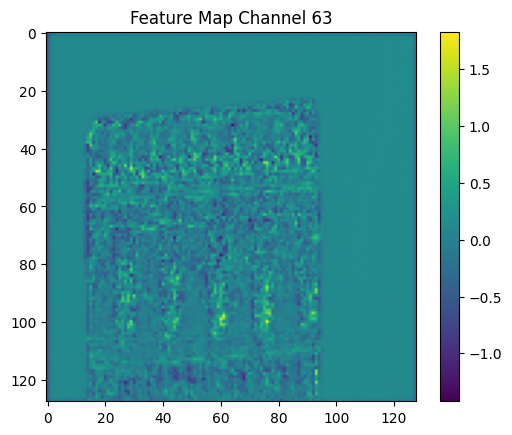

In [9]:
# Visualize a specific channel (e.g., channel 0)
channel = 63  # You can change this to any channel number

plt.imshow(selected_feature_map[0, channel, :, :].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title(f"Feature Map Channel {channel}")
plt.show()

In [10]:
# Find embedding for a specific pixel
def retrieve_embedding(feature_maps, x, y):
    embedding = []
    scale = 2

    # All Transformer blocks (OUTPUTS)
    for idx, features in enumerate(feature_maps):

        if features.shape[0] == 0:
            continue

        # Scale down coordinates
        scaled_x = int(x // (scale**idx))
        scaled_y = int(y // (scale**idx))

        # Append the embedding
        pixel_embedding = features[0, :, scaled_x, scaled_y].cpu().numpy()
        embedding.append(pixel_embedding)

    return np.concatenate(embedding) 

In [11]:
embedding = retrieve_embedding(feature_maps, 500, 100)
print(len(embedding))

1027


In [12]:
def get_feature_map(image_path, encoder):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (512, 512))
    t = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])
    img = t(img)
    img = img.unsqueeze(0) # add batch dimension
    with torch.no_grad():
        feature_maps = encoder(img)
    return feature_maps

In [13]:
def get_predictions(image_path, model):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (512, 512))
    t = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])
    img = t(img)
    img = img.unsqueeze(0) # add batch dimension
    with torch.no_grad():
        output = model(img)
    output = torch.argmax(F.softmax(output, dim=1), dim=1) # softmax: om logits --> probabilities --> klasse index
    return output

In [14]:
predictions = get_predictions('dataset/images/0.jpg', model)

In [15]:
def create_df():
    name = []
    filenames = os.listdir("dataset/images")
    filenames = sorted(filenames, key=lambda x : int(x.split('.')[0]))
    for filename in filenames:
        name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [16]:
df = create_df()

X_train, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19) # split the data into train and test sets
X_train, X_val = train_test_split(X_train, test_size=0.15, random_state=19) # validate on 15% of the training data

In [17]:
# Read classes json
import json

with open('obj_class_to_machine_color.json', 'r') as f:
    classes = json.load(f)

# List of classes
class_labels = []
for key, value in classes.items():
    class_labels.append(key)

print(len(class_labels))

important_classes = [
        'Ionic kyma decoration', 
        'Lesbian kyma decoration', 
        'Bead-and-reel (double double)', 
        'Scroll pattern (large)', 
        'Anthemion (large & capital & pulvinus)', 
        'Anthemion (small & soffit & top moulding architrave)', 
        'Acanthus leaves (solo) (capital & frieze & modillion)'
    ]

labels_import_classes = [6, 1, 15, 12, 2, 30, 29]

36


### Calculate per image the average embedding for each important class.

In [18]:
# Segformer
model = sm.Segformer('mit_b2', encoder_weights='imagenet', classes=37, activation=None)

# load checkpoint
model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map_location=device))

encoder = model.encoder

/tmp/ipykernel_9903/1628315217.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('runs/512x512/segformer_mit_b2/best_model_epoch.pth', map

In [19]:
import numpy as np

global_label_embeddings = {}

# Go through all test images
for img_name in X_test:
    output_pred = get_predictions(f'dataset/images/{img_name}.jpg', model)
    feature_maps = get_feature_map(f'dataset/images/{img_name}.jpg', encoder)

    unique_labels = np.unique(output_pred.numpy()) # Get unique labels in the prediction

    for label in tqdm(unique_labels):
        if label in labels_import_classes:  # Only consider important classes
            # Get X and Y coordinates of all pixels with current important label
            x, y = np.where(output_pred.numpy()[0] == label) 

            if len(x) == 0:
                continue

            label_embeddings = []
            
            # Retrieve the embedding for each pixel with the current label
            for i in range(len(x)):
                pixel_embedding = retrieve_embedding(feature_maps, x[i], y[i])
                label_embeddings.append(pixel_embedding)
                
            # Calculate the mean embedding for the label in this image
            label_embeddings = np.array(label_embeddings)  # Convert to NumPy array
            mean_embedding = np.mean(label_embeddings, axis=0)
            
            # Add the mean embedding to the global dictionary
            if label not in global_label_embeddings:
               global_label_embeddings[label] = []
            global_label_embeddings[label].append(mean_embedding)

    print(f"Processed image: {img_name}")
      

100%|██████████| 9/9 [00:14<00:00,  1.64s/it]


Processed image: 420


100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


Processed image: 339


100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Processed image: 67


100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Processed image: 45


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Processed image: 19


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


Processed image: 106


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Processed image: 480


100%|██████████| 11/11 [00:00<00:00, 17.34it/s]


Processed image: 392


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Processed image: 341


100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


Processed image: 147


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Processed image: 344


100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


Processed image: 407


100%|██████████| 7/7 [00:00<00:00, 38.29it/s]


Processed image: 247


100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


Processed image: 412


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Processed image: 460


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


Processed image: 210


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Processed image: 229


100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


Processed image: 336


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Processed image: 443


100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


Processed image: 325


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Processed image: 150


100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Processed image: 353


100%|██████████| 12/12 [00:00<00:00, 14.26it/s]


Processed image: 382


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Processed image: 311


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


Processed image: 478


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


Processed image: 266


100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Processed image: 103


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Processed image: 254


100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


Processed image: 278


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Processed image: 314


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Processed image: 280


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Processed image: 44


100%|██████████| 9/9 [00:16<00:00,  1.86s/it]


Processed image: 329


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Processed image: 270


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Processed image: 421


100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


Processed image: 462


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Processed image: 346


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


Processed image: 175


100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Processed image: 397


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


Processed image: 431


100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Processed image: 70


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


Processed image: 294


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Processed image: 352


100%|██████████| 7/7 [00:00<00:00, 34.04it/s]


Processed image: 233


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Processed image: 403


100%|██████████| 8/8 [00:01<00:00,  4.70it/s]


Processed image: 57


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Processed image: 130


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Processed image: 195


100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


Processed image: 477


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Processed image: 435


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


Processed image: 231


100%|██████████| 7/7 [00:15<00:00,  2.18s/it]


Processed image: 46


100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Processed image: 322


100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Processed image: 263


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Processed image: 483


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


Processed image: 151


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Processed image: 238


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


Processed image: 283


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Processed image: 132


100%|██████████| 16/16 [00:02<00:00,  7.16it/s]


Processed image: 282


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Processed image: 484


100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Processed image: 48


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


Processed image: 202


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Processed image: 112


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


Processed image: 50


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Processed image: 223


100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Processed image: 177


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Processed image: 47


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


Processed image: 334


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


Processed image: 253


100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


Processed image: 279


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Processed image: 389


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Processed image: 418


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Processed image: 78


100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Processed image: 140


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Processed image: 441


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Processed image: 172


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Processed image: 18


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Processed image: 153


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Processed image: 491


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Processed image: 360


100%|██████████| 8/8 [00:13<00:00,  1.66s/it]


Processed image: 128


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Processed image: 410


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Processed image: 295


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Processed image: 230


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Processed image: 264


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Processed image: 111


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Processed image: 475


100%|██████████| 4/4 [00:12<00:00,  3.08s/it]


Processed image: 297


100%|██████████| 17/17 [00:11<00:00,  1.42it/s]


Processed image: 404


100%|██████████| 18/18 [00:12<00:00,  1.47it/s]


Processed image: 414


100%|██████████| 10/10 [00:00<00:00, 13.36it/s]


Processed image: 246


100%|██████████| 7/7 [00:10<00:00,  1.48s/it]


Processed image: 379


100%|██████████| 18/18 [00:05<00:00,  3.44it/s]


Processed image: 242


100%|██████████| 11/11 [00:00<00:00, 14.96it/s]


Processed image: 25


100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


Processed image: 20


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Processed image: 65


100%|██████████| 4/4 [00:12<00:00,  3.20s/it]


Processed image: 243


100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Processed image: 180


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Processed image: 368


100%|██████████| 9/9 [00:16<00:00,  1.81s/it]


Processed image: 319


100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Processed image: 375


100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Processed image: 54


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Processed image: 118


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Processed image: 154


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


Processed image: 7


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Processed image: 331


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


Processed image: 300


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Processed image: 179


100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Processed image: 43


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


Processed image: 53


100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


Processed image: 251


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Processed image: 56


100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Processed image: 209


100%|██████████| 4/4 [00:16<00:00,  4.12s/it]


Processed image: 377


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Processed image: 90


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Processed image: 100


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Processed image: 284


100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Processed image: 14


100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


Processed image: 476


100%|██████████| 4/4 [00:00<00:00, 92.52it/s]


Processed image: 349


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


Processed image: 15


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Processed image: 239


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Processed image: 482


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Processed image: 189


100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Processed image: 222


100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Processed image: 387


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Processed image: 342


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Processed image: 135


100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Processed image: 3


100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Processed image: 201


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Processed image: 13


100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Processed image: 116


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Processed image: 102


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Processed image: 276


100%|██████████| 14/14 [00:12<00:00,  1.08it/s]


Processed image: 425


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


Processed image: 2


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Processed image: 182


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Processed image: 308


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Processed image: 148


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Processed image: 73


100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


Processed image: 207


100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


Processed image: 123


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Processed image: 9


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


Processed image: 357


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]


Processed image: 428


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Processed image: 77


100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


Processed image: 305


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Processed image: 127


100%|██████████| 14/14 [00:14<00:00,  1.06s/it]


Processed image: 286


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Processed image: 354


100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Processed image: 417


100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Processed image: 373


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Processed image: 337


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Processed image: 101


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Processed image: 369


100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


Processed image: 277


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Processed image: 40


100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


Processed image: 296


100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


Processed image: 463


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Processed image: 29


100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Processed image: 200


100%|██████████| 3/3 [00:09<00:00,  3.25s/it]


Processed image: 186


100%|██████████| 14/14 [00:02<00:00,  5.17it/s]


Processed image: 315


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Processed image: 445


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Processed image: 184


100%|██████████| 18/18 [00:02<00:00,  6.87it/s]


Processed image: 113


100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


Processed image: 181


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Processed image: 74


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Processed image: 167


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Processed image: 364


100%|██████████| 10/10 [00:00<00:00, 28.25it/s]


Processed image: 481


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Processed image: 11


100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Processed image: 422


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Processed image: 22


100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


Processed image: 131


100%|██████████| 11/11 [00:08<00:00,  1.33it/s]


Processed image: 30


100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


Processed image: 327


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Processed image: 416


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


Processed image: 430


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Processed image: 436


100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


Processed image: 399


100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Processed image: 449


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


Processed image: 292


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


Processed image: 63


100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


Processed image: 321


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Processed image: 134


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Processed image: 474


100%|██████████| 8/8 [00:00<00:00, 11.73it/s]


Processed image: 4


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


Processed image: 393


100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


Processed image: 240


100%|██████████| 6/6 [00:00<00:00, 48.82it/s]


Processed image: 316


100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


Processed image: 119


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Processed image: 400


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Processed image: 467


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Processed image: 41


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


Processed image: 149


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Processed image: 374


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Processed image: 359


100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Processed image: 0


100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Processed image: 298


100%|██████████| 14/14 [00:05<00:00,  2.35it/s]


Processed image: 234


100%|██████████| 11/11 [00:03<00:00,  3.13it/s]


Processed image: 396


100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


Processed image: 291


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Processed image: 137


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Processed image: 470


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Processed image: 52


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Processed image: 193


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Processed image: 60


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Processed image: 221


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Processed image: 144


100%|██████████| 7/7 [00:15<00:00,  2.21s/it]


Processed image: 93


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Processed image: 426


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Processed image: 198


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Processed image: 328


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Processed image: 317


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Processed image: 271


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Processed image: 378


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Processed image: 258


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Processed image: 471


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Processed image: 94


100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


Processed image: 302


100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Processed image: 203


100%|██████████| 9/9 [00:18<00:00,  2.00s/it]


Processed image: 236


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


Processed image: 64


100%|██████████| 6/6 [00:16<00:00,  2.74s/it]


Processed image: 146


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Processed image: 214


100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


Processed image: 219


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Processed image: 28


100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Processed image: 141


100%|██████████| 11/11 [00:07<00:00,  1.43it/s]


Processed image: 183


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


Processed image: 26


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


Processed image: 340


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Processed image: 466


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Processed image: 196


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Processed image: 324


100%|██████████| 9/9 [00:14<00:00,  1.58s/it]


Processed image: 330


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Processed image: 427


100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Processed image: 32


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Processed image: 110


100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Processed image: 158


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


Processed image: 76


100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


Processed image: 160


100%|██████████| 6/6 [00:19<00:00,  3.31s/it]


Processed image: 80


100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


Processed image: 34


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Processed image: 440


100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Processed image: 213


100%|██████████| 5/5 [00:00<00:00, 11.25it/s]


Processed image: 91


100%|██████████| 9/9 [00:03<00:00,  2.94it/s]


Processed image: 169


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Processed image: 424


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Processed image: 166


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Processed image: 199


100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


Processed image: 343


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Processed image: 31


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


Processed image: 6


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


Processed image: 312


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Processed image: 145


100%|██████████| 11/11 [00:08<00:00,  1.25it/s]


Processed image: 162


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Processed image: 176


100%|██████████| 5/5 [00:00<00:00, 85.74it/s]


Processed image: 391


100%|██████████| 6/6 [00:00<00:00, 10.46it/s]


Processed image: 289


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Processed image: 178


100%|██████████| 8/8 [00:00<00:00,  8.51it/s]


Processed image: 366


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


Processed image: 98


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Processed image: 82


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Processed image: 376


100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


Processed image: 156


100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Processed image: 227


100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


Processed image: 105


100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Processed image: 129


100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Processed image: 109


100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


Processed image: 191


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Processed image: 472


100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


Processed image: 173


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


Processed image: 362


100%|██████████| 9/9 [00:00<00:00, 16.83it/s]


Processed image: 310


100%|██████████| 6/6 [00:00<00:00, 13.40it/s]


Processed image: 61


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Processed image: 220


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Processed image: 361


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Processed image: 92


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Processed image: 380


100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


Processed image: 72


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Processed image: 456


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Processed image: 124


100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


Processed image: 388


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Processed image: 437


100%|██████████| 3/3 [00:14<00:00,  4.94s/it]


Processed image: 272


100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Processed image: 439


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Processed image: 139


100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Processed image: 489


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Processed image: 473


100%|██████████| 11/11 [00:01<00:00,  6.05it/s]


Processed image: 107


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Processed image: 217


100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Processed image: 208


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Processed image: 268


100%|██████████| 9/9 [00:00<00:00, 19.94it/s]


Processed image: 409


100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


Processed image: 143


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Processed image: 457


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Processed image: 365


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Processed image: 313


100%|██████████| 11/11 [00:02<00:00,  4.83it/s]


Processed image: 464


100%|██████████| 5/5 [00:08<00:00,  1.80s/it]


Processed image: 86


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


Processed image: 39


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Processed image: 255


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Processed image: 33


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Processed image: 385


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Processed image: 168


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Processed image: 152


100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


Processed image: 84


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


Processed image: 161


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Processed image: 485


100%|██████████| 6/6 [00:00<00:00, 30.22it/s]


Processed image: 97


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Processed image: 62


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Processed image: 197


100%|██████████| 7/7 [00:14<00:00,  2.13s/it]


Processed image: 159


100%|██████████| 10/10 [00:00<00:00, 12.73it/s]


Processed image: 383


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Processed image: 411


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Processed image: 95


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Processed image: 194


100%|██████████| 7/7 [00:00<00:00, 45.94it/s]


Processed image: 307


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Processed image: 267


100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


Processed image: 351


100%|██████████| 6/6 [00:00<00:00, 18.22it/s]


Processed image: 384


100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


Processed image: 1


100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Processed image: 398


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Processed image: 408


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


Processed image: 433


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


Processed image: 252


100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Processed image: 188


100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


Processed image: 104


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


Processed image: 402


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Processed image: 164


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Processed image: 326


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Processed image: 16


100%|██████████| 6/6 [00:17<00:00,  2.92s/it]


Processed image: 299


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


Processed image: 259


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Processed image: 260


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Processed image: 487


100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


Processed image: 304


100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Processed image: 458


100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Processed image: 335


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Processed image: 309


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Processed image: 17


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Processed image: 444


100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


Processed image: 215


100%|██████████| 3/3 [00:06<00:00,  2.29s/it]


Processed image: 419


100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Processed image: 453


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Processed image: 218


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Processed image: 381


100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


Processed image: 293


100%|██████████| 11/11 [00:07<00:00,  1.40it/s]


Processed image: 206


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


Processed image: 81


100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Processed image: 228


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


Processed image: 275


100%|██████████| 8/8 [00:01<00:00,  7.73it/s]


Processed image: 479


100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Processed image: 285


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Processed image: 256


100%|██████████| 9/9 [00:02<00:00,  3.65it/s]


Processed image: 85


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Processed image: 5


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Processed image: 332


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Processed image: 170


100%|██████████| 9/9 [00:02<00:00,  3.41it/s]


Processed image: 23


100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Processed image: 450


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Processed image: 224


100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Processed image: 455


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Processed image: 281


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


Processed image: 423


100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


Processed image: 249


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Processed image: 355


100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Processed image: 117


100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


Processed image: 306


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Processed image: 372


100%|██████████| 10/10 [00:01<00:00,  9.26it/s]


Processed image: 58


100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Processed image: 301


100%|██████████| 6/6 [00:15<00:00,  2.59s/it]

Processed image: 226


In [20]:
print(global_label_embeddings.keys())

print(len(global_label_embeddings.values()))

print(len(global_label_embeddings[1]))

dict_keys([np.int64(1), np.int64(2), np.int64(6), np.int64(15), np.int64(29), np.int64(30), np.int64(12)])
7
246


['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue',

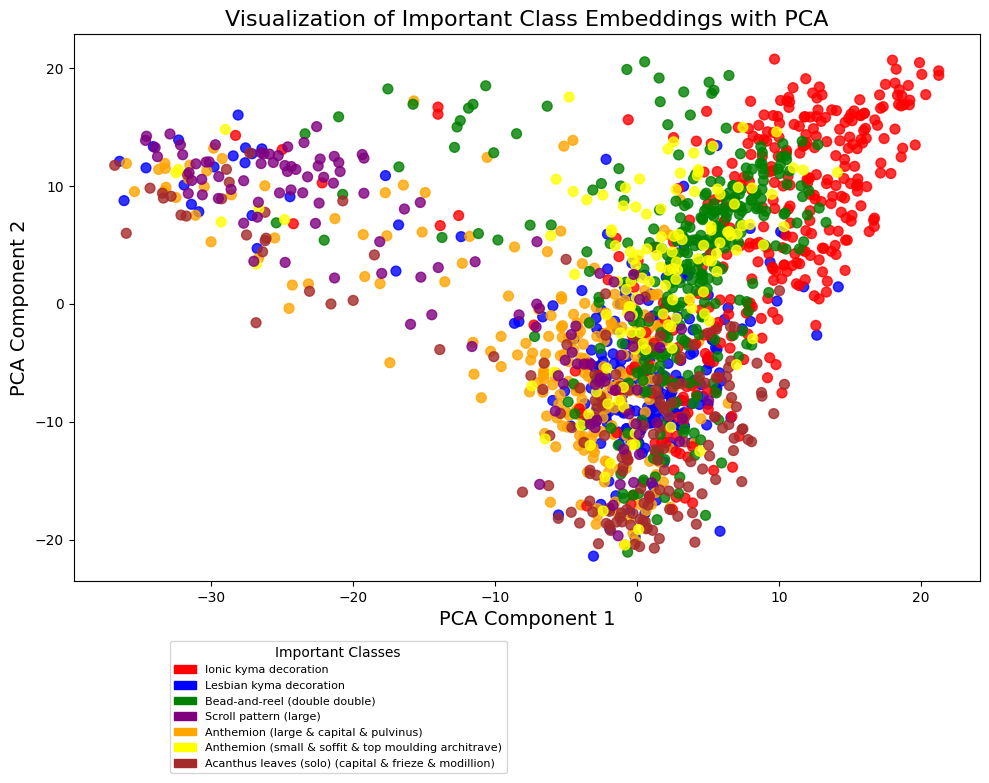

In [21]:
from sklearn.decomposition import PCA


# List of important classes and their corresponding labels
important_classes = [
    'Ionic kyma decoration', 
    'Lesbian kyma decoration', 
    'Bead-and-reel (double double)', 
    'Scroll pattern (large)', 
    'Anthemion (large & capital & pulvinus)', 
    'Anthemion (small & soffit & top moulding architrave)', 
    'Acanthus leaves (solo) (capital & frieze & modillion)'
]

labels_import_classes = [6, 1, 15, 12, 2, 30, 29]

# Create a mapping of class labels to specific colors (you can change these colors)
color_map = {
    6: 'red',
    1: 'blue',
    15: 'green',
    12: 'purple',
    2: 'orange',
    30: 'yellow',
    29: 'brown'
}

# Combine embeddings into a single array and track labels
embeddings = []
labels = []

for label, arrays in global_label_embeddings.items():
    for arr in arrays:
        embeddings.append(arr)  # Add embedding
        labels.append(label)    # Add corresponding 

embeddings = np.vstack(embeddings)  # Combine into 2D array

# Reduce dimensions with PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
reduced_embeddings = pca.fit_transform(embeddings)

# Create color array for each label
colors = [color_map.get(label) for label in labels]  # Default color 'gray' for non-important labels
print(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, s=50, alpha=0.8)

# Create a legend   
import matplotlib.patches as mpatches

legend_labels = [mpatches.Patch(color=color_map[label], label=important_classes[i]) for i, label in enumerate(labels_import_classes)]

plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(0.1, -0.1), title="Important Classes", fontsize=8)

plt.title("Visualization of Important Class Embeddings with PCA", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)

# Adjust layout to fit the plot and legend
plt.tight_layout()

plt.show()


/home/tenzing/apollo/avc/projects/archaeology/.myvenv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue',

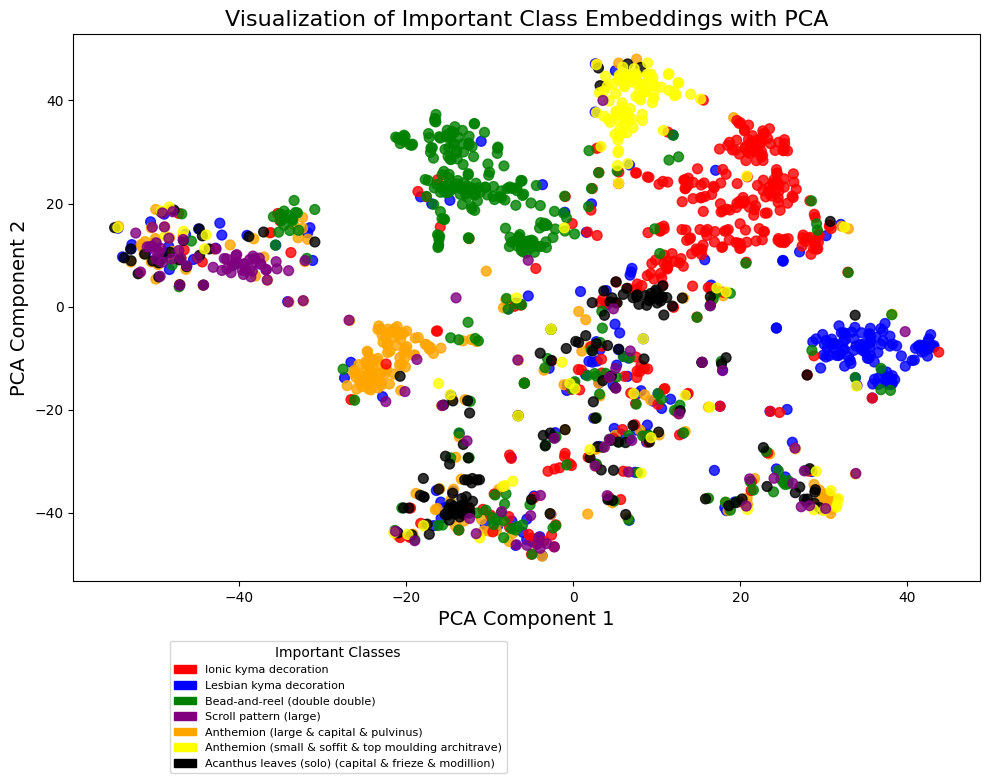

In [22]:
# Initialize TSNE
from sklearn.manifold import TSNE


# List of important classes and their corresponding labels
important_classes = [
    'Ionic kyma decoration', 
    'Lesbian kyma decoration', 
    'Bead-and-reel (double double)', 
    'Scroll pattern (large)', 
    'Anthemion (large & capital & pulvinus)', 
    'Anthemion (small & soffit & top moulding architrave)', 
    'Acanthus leaves (solo) (capital & frieze & modillion)'
]

labels_import_classes = [6, 1, 15, 12, 2, 30, 29]

# Create a mapping of class labels to specific colors (you can change these colors)
color_map = {
    6: 'red',
    1: 'blue',
    15: 'green',
    12: 'purple',
    2: 'orange',
    30: 'yellow',
    29: 'black'
}

# Combine embeddings into a single array and track labels
embeddings = []
labels = []

for label, arrays in global_label_embeddings.items():
    for arr in arrays:
        embeddings.append(arr)  # Add embedding
        labels.append(label)    # Add corresponding 

embeddings = np.vstack(embeddings)  # Combine into 2D array

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)


pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_pca)


# Create color array for each label
colors = [color_map.get(label) for label in labels]  # Default color 'gray' for non-important labels
print(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, s=50, alpha=0.8)

# Create a legend   
import matplotlib.patches as mpatches

legend_labels = [mpatches.Patch(color=color_map[label], label=important_classes[i]) for i, label in enumerate(labels_import_classes)]

plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(0.1, -0.1), title="Important Classes", fontsize=8)

plt.title("Visualization of Important Class Embeddings with PCA", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)

# Adjust layout to fit the plot and legend
plt.tight_layout()

plt.show()